In [1]:
%load_ext autoreload
%autoreload 2
from functools import partial

import matplotlib.pyplot as plt
import torch
import pyro.distributions as dist
from scipy import stats
from torch import Tensor

from bayesian_stats.mcmc import run_mcmc

# Beta-binomial example
What is the probability a coin is materially biases towards heads ($P(heads) > 52.5\%$), given we flipped it 250 times and observed 140 heads?What is the probability a coin is materially biases towards heads ($P(heads) > 52.5\%$), given we flipped it 250 times and observed 140 heads?

We'll set our prior to convey significant skepticism the coin is biased: $P(heads) \sim beta(a=100, b=100)$

## Analytic solution using beta-binomial conjugate

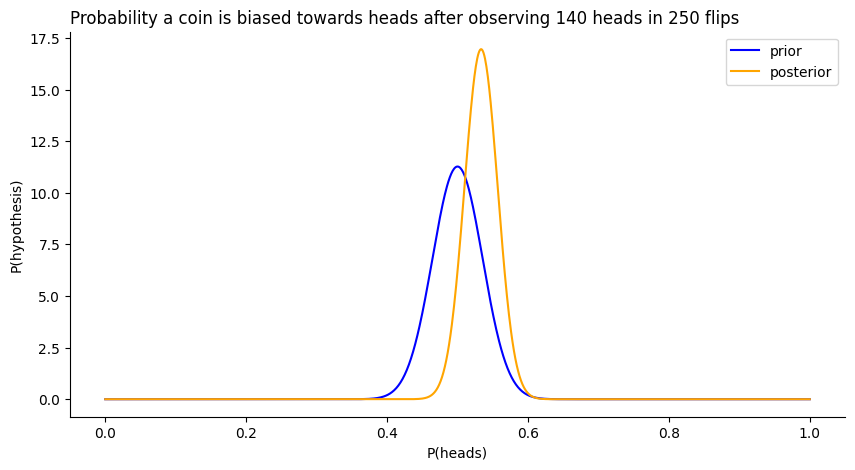

In [2]:
prior = dist.Beta(100, 100)
posterior = dist.Beta(100 + 140, 100 + 250 - 140)
_, ax = plt.subplots(figsize=(10,5))

p_heads = torch.linspace(0, 1, 1001)
ax.plot(p_heads, torch.exp(prior.log_prob(p_heads)), label="prior", color="blue")
ax.plot(p_heads, torch.exp(posterior.log_prob(p_heads)), label="posterior", color="orange")
ax.spines[['right', 'top']].set_visible(False)
ax.set_title(
    "Probability a coin is biased towards heads after observing 140 heads in 250 flips",
    loc='left', 
    fontdict={'fontsize': 12}
)
ax.set_xlabel("P(heads)")
ax.set_ylabel("P(hypothesis)")
ax.legend()

## Approximate solution using MCMC

In [96]:
def prior(a: float, b: float, p: Tensor) -> Tensor:
    return dist.Beta(a, b).log_prob(p)

def likelihood(p: Tensor, n: int, k: int) -> Tensor:
    return dist.Binomial(total_count=n, probs=p).log_prob(torch.tensor(k))

result = run_mcmc(
    parameter_bounds=dict(p=(0., 1.)),
    prior=partial(prior, a=100, b=100),
    likelihood=partial(likelihood, n=250, k=140),
    num_samples=2**10,
    max_iter=1_000,
    tol=5e-4,
)

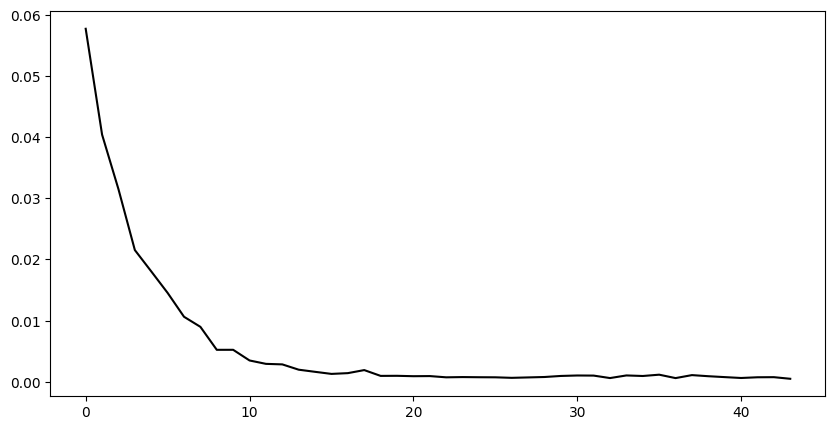

In [105]:
_, ax = plt.subplots(figsize=(10,5))
ax.plot(result.wasserstein_distance_trace[:,0], color="black")

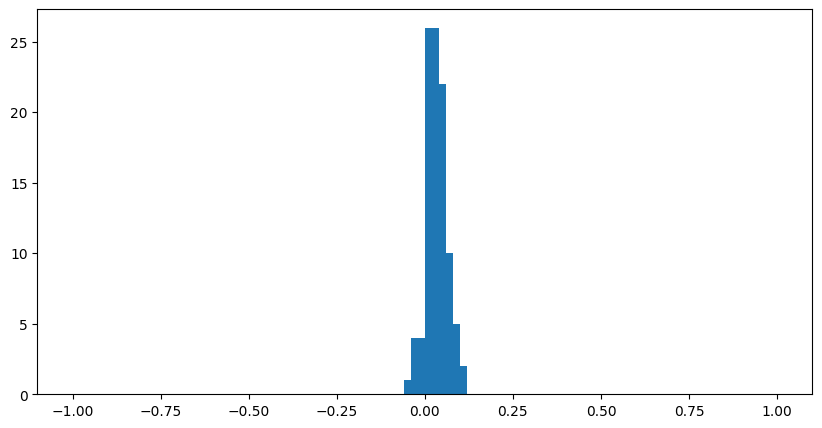

In [108]:
corr_to_init = result.get_correlation_to_init()
_, ax = plt.subplots(figsize=(10,5))
_ = ax.hist(corr_to_init["p"], bins=torch.linspace(-1, 1, 101))

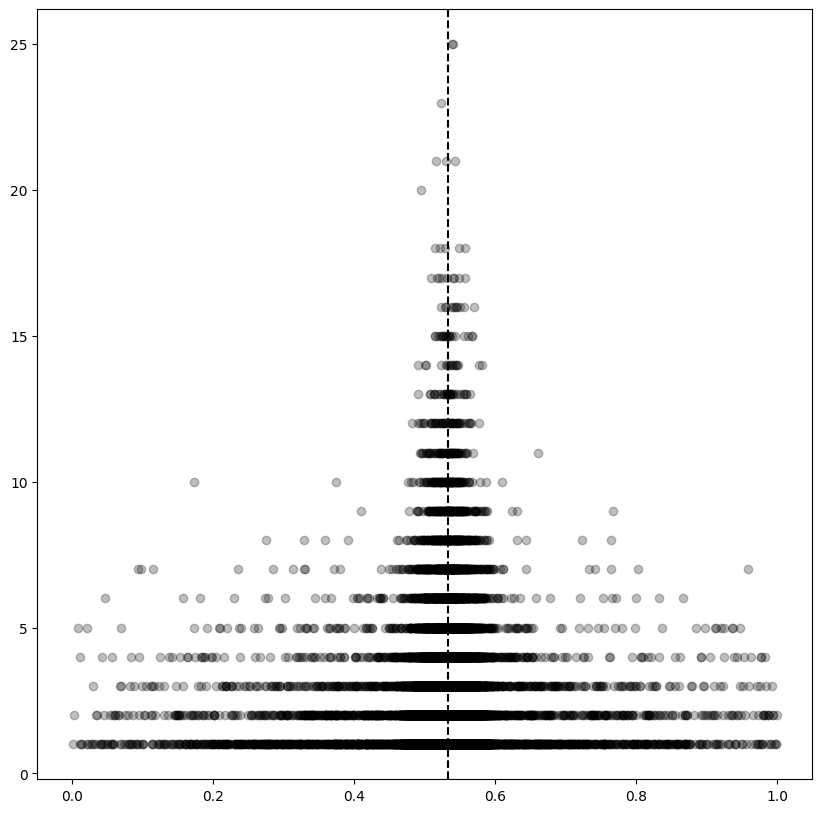

In [104]:
_, ax = plt.subplots(figsize=(10,10))
ax.scatter(
    result.sample_counter["p"].keys(),
    result.sample_counter["p"].values(),
    alpha=0.25,
    color="black",
)
ax.axvline(x=result.get_map_estimate("p"), label="MAP estimate", color="black", linestyle="--")

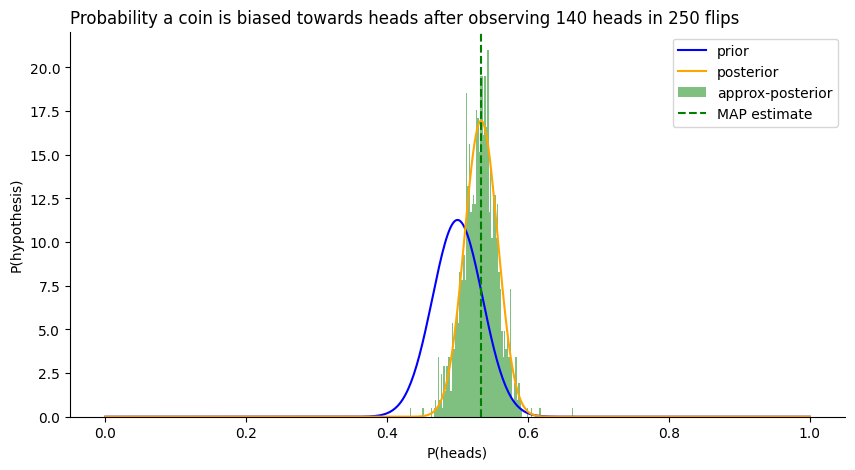

In [103]:
prior = dist.Beta(100, 100)
posterior = dist.Beta(100 + 140, 100 + 250 - 140)
_, ax = plt.subplots(figsize=(10,5))

p_heads = torch.linspace(0, 1, 501)
ax.plot(p_heads, torch.exp(prior.log_prob(p_heads)), label="prior", color="blue")
ax.plot(p_heads, torch.exp(posterior.log_prob(p_heads)), label="posterior", color="orange")
ax.hist(result.get_samples("p"), bins=p_heads, density=True, label="approx-posterior", color="green", alpha=0.5)
ax.axvline(x=result.get_map_estimate("p"), label="MAP estimate", color="green", linestyle="--")
ax.spines[['right', 'top']].set_visible(False)
ax.set_title(
    "Probability a coin is biased towards heads after observing 140 heads in 250 flips",
    loc='left', 
    fontdict={'fontsize': 12}
)
ax.set_xlabel("P(heads)")
ax.set_ylabel("P(hypothesis)")
ax.legend()